# **VGG16: Image Modality for informative task**
Se usa la arquitectura de redes neuronales convolucionales desarrollada por la Universidad de Oxford.

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pandas as pd
from PIL import Image
import os

2025-11-25 11:10:13.693905: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### **Preprocesamiento de imágenes**
- Redimensionar y normalizar (224x224)
- Valores de los pixeles entre 0 y 1
- Normalizar los canales de color con respecto al dataset ImageNet

In [5]:
# Los datos ya fueron preprocesados y guardados como archivos .npy
# Falta cargar los datos
default_path = "/home/jacruz/crisis/data/preprocessed_images/"
df = pd.read_csv("/home/jacruz/crisis/data/crisis_images_dataset.csv")

image_names = df['image_name'].tolist()
labels = df['image_info'].tolist()

In [6]:
image_paths = [default_path + name + '.npy' for name in image_names]
image_paths[:5]

['/home/jacruz/crisis/data/preprocessed_images/917791044158185473_0.npy',
 '/home/jacruz/crisis/data/preprocessed_images/917791130590183424_0.npy',
 '/home/jacruz/crisis/data/preprocessed_images/917791291823591425_0.npy',
 '/home/jacruz/crisis/data/preprocessed_images/917791291823591425_1.npy',
 '/home/jacruz/crisis/data/preprocessed_images/917792092100988929_0.npy']

In [7]:
image_path = image_paths[0]
if not os.path.exists(image_path):
                print(f"Archivo no encontrado: {image_path}")

In [8]:
def load_images_from_paths(image_paths, target_size=(224, 224)):
    """
    Carga imágenes desde rutas de archivo
    """
    images = []
    valid_indices = []
    
    print(f"Cargando {len(image_paths)} imágenes desde rutas...")
    
    for i, npy_path in enumerate(image_paths):
        try:
            # Verificar si el archivo existe
            if not os.path.exists(npy_path):
                print(f"Archivo no encontrado: {npy_path}")
                continue
                
            # Cargar array numpy
            img_array = np.load(npy_path)
            
            images.append(img_array)
            valid_indices.append(i)
            
        except Exception as e:
            print(f"Error cargando imagen {npy_path}: {e}")
            print(f"Forma del array: {img_array.shape}" if 'img_array' in locals() else "No se pudo cargar el array.")
            continue
            
        # Mostrar progreso cada 1000 imágenes
        if (i + 1) % 1000 == 0:
            print(f"Procesadas {i + 1}/{len(image_paths)} imágenes")
    
    print(f"Imágenes cargadas exitosamente: {len(images)}/{len(image_paths)}")
    
    return np.array(images), valid_indices

In [9]:

def load_and_prepare_data():
    """
    Carga los arrays numpy preprocesados (.npy) y prepara para entrenamiento
    """
    # Cargar los arrays
    X_paths = np.array(image_paths)
    y_labels = np.array(labels)
    
    # Verificar formas
    print(f"Número de rutas de imágenes: {len(X_paths)}")
    print(f"Número de etiquetas: {len(y_labels)}")

    # Cargar imágenes desde las rutas
    X_images, valid_indices = load_images_from_paths(X_paths)

    # Filtrar etiquetas para mantener solo las correspondientes a imágenes cargadas exitosamente
    y_labels_filtered = y_labels[valid_indices]
    
    # Mapeo manual de labels a números
    # Según el paper: 0 = Not-informative, 1 = Informative
    label_mapping = {'not_informative': 0, 'informative': 1}
    
    # Convertir etiquetas de texto a numéricas
    y_numeric = np.array([label_mapping[label] for label in y_labels_filtered])
    
    print(f"Distribución de etiquetas:")
    print(f"Non-informative (0): {np.sum(y_numeric == 0)}")
    print(f"Informative (1): {np.sum(y_numeric == 1)}")

    # Se asegura de tener el formato correcto
    X_images = X_images.astype('float32')

    y_categorical = to_categorical(y_numeric, num_classes=2)

    print(f"Rango de valores en X: min {X_images.min():.3f}, max {X_images.max():.3f}")

    print(f"Forma final de X: {X_images.shape}")
    print(f"Forma final de y: {y_categorical.shape}")
    return X_images, y_categorical

def split_data(X, y, test_size=0.3, val_size=0.5):
    """
    Divide los datos en train, validation y test y convierte a arrays numpy
    """
    X = np.array(X)
    y = np.array(y)

    print(f"Forma de X antes de split: {X.shape}")
    print(f"Forma de y antes de split: {y.shape}")

    # Primera división: train vs (val + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # Segunda división: val vs test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=val_size, random_state=42, stratify=y_temp
    )

    print(f"Formas después del split:")
    print(f"Forma de X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Forma de X_val: {X_val.shape}, y_val: {y_val.shape}")
    print(f"Forma de X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

### **Arquitectura del modelo**
Se usa el modelo pre-entrenado VGG16 para aplicar transfer learning
- Se busca reutilizar los pesos
- Se reemplaza la última capa por _softmax_ 

In [10]:

def create_vgg16_model(num_classes=2, input_shape=(224, 224, 3)):
    """
    Crea el modelo VGG16 para clasificación binaria
    según la descripción del paper
    """
    # Cargar VGG16 pre-entrenado en ImageNet (sin la capa final)
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Congelar las capas convolucionales (transfer learning)
    for layer in base_model.layers:
        layer.trainable = False
    
    # Añadir capas personalizadas según el paper
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation='relu')(x)  # Capa fc2 mencionada en el paper
    x = BatchNormalization()(x)
    x = Dropout(0.02)(x)  # Dropout rate usado en el paper
    
    # Capa de salida
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Modelo final
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

### **Entrenamiento**
- Uso del Adam optimizer con initial learning rate de 10^-6
- Se reduce la tasa de aprendizaje en 0.1 si el accuracy deja de mejorar después de las 100 épocas
- El máximo de épocas es 1000, con early stopping

In [11]:
def setup_training(model):
    """
    Configura el optimizador y callbacks según el paper
    """
    # Optimizador Adam con learning rate muy bajo (1e-6) como en el paper
    optimizer = Adam(learning_rate=1e-6)
    
    # Callbacks
    callbacks = [
        # Early stopping con paciencia de 100 epochs (como en el paper)
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=100,
            restore_best_weights=True
        ),
        # ReduceLROnPlateau (mencionado en el paper)
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.1,
            patience=50,
            min_lr=1e-8
        ),
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'best_vgg16_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        # CSV Logger para registrar el historial de entrenamiento
        tf.keras.callbacks.CSVLogger(
            'training_history.csv',
            separator=',',
            append=False
        )
    ]
    
    # Compilar modelo
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    
    return callbacks

### **Evaluación del modelo**

In [12]:

def evaluate_model(model, X_test, y_test):
    """
    Evaluación completa del modelo
    """
    # Predicciones
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Classification report
    print("Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, 
                              target_names=['Not-informative', 'Informative']))
    
    # Matriz de confusión
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not-inf', 'Inf'],
                yticklabels=['Not-inf', 'Inf'])
    plt.title('Matriz de Confusión - VGG16')
    plt.ylabel('Verdadero')
    plt.xlabel('Predicho')
    plt.show()
    
    return y_pred_classes, y_true_classes

### **Curvas de aprendizaje**

In [13]:
def plot_learning_curves(history):
    """
    Grafica las curvas de aprendizaje a partir del historial de entrenamiento
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Curva de pérdida
    axes[0, 0].plot(history.history['loss'], label='Train Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 0].set_title('Pérdida durante el entrenamiento')
    axes[0, 0].set_xlabel('Época')
    axes[0, 0].set_ylabel('Pérdida')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Curva de accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0, 1].set_title('Accuracy durante el entrenamiento')
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Curva de precision
    axes[1, 0].plot(history.history['precision'], label='Train Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
    axes[1, 0].set_title('Precision durante el entrenamiento')
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Curva de recall
    axes[1, 1].plot(history.history['recall'], label='Train Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
    axes[1, 1].set_title('Recall durante el entrenamiento')
    axes[1, 1].set_xlabel('Época')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # También graficar F1-score
    train_f1 = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(history.history['precision'], history.history['recall'])]
    val_f1 = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(history.history['val_precision'], history.history['val_recall'])]
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_f1, label='Train F1-score')
    plt.plot(val_f1, label='Val F1-score')
    plt.title('F1-score durante el entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('F1-score')
    plt.legend()
    plt.grid(True)
    plt.savefig('f1_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

### **Experimento**

Cargando datos...
Número de rutas de imágenes: 18082
Número de etiquetas: 18082
Cargando 18082 imágenes desde rutas...
Procesadas 1000/18082 imágenes
Procesadas 2000/18082 imágenes
Procesadas 3000/18082 imágenes
Procesadas 4000/18082 imágenes
Procesadas 5000/18082 imágenes
Procesadas 6000/18082 imágenes
Procesadas 7000/18082 imágenes
Procesadas 8000/18082 imágenes
Procesadas 9000/18082 imágenes
Procesadas 10000/18082 imágenes
Procesadas 11000/18082 imágenes
Procesadas 12000/18082 imágenes
Procesadas 13000/18082 imágenes
Procesadas 14000/18082 imágenes
Procesadas 15000/18082 imágenes
Procesadas 16000/18082 imágenes
Procesadas 17000/18082 imágenes
Procesadas 18000/18082 imágenes
Imágenes cargadas exitosamente: 18082/18082
Distribución de etiquetas:
Non-informative (0): 8708
Informative (1): 9374
Rango de valores en X: min -2.118, max 2.640
Forma final de X: (18082, 224, 224, 3)
Forma final de y: (18082, 2)
Dividiendo datos...
Forma de X antes de split: (18082, 224, 224, 3)
Forma de y ant

2025-11-25 11:15:10.017330: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 7620931584 exceeds 10% of free system memory.
2025-11-25 11:15:15.072400: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 7620931584 exceeds 10% of free system memory.


Epoch 1/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5379 - loss: 0.8294 - precision: 0.5379 - recall: 0.5379

396/396 ━━━━━━━━━━━━━━━━━━━━ 28s 65ms/step - accuracy: 0.5605 - loss: 0.7869 - precision: 0.5605 - recall: 0.5605 - val_accuracy: 0.5999 - val_loss: 0.6702 - val_precision: 0.5999 - val_recall: 0.5999 - learning_rate: 1.0000e-06
Epoch 2/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6072 - loss: 0.7057 - precision: 0.6072 - recall: 0.6072

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6237 - loss: 0.6913 - precision: 0.6237 - recall: 0.6237 - val_accuracy: 0.6372 - val_loss: 0.6629 - val_precision: 0.6372 - val_recall: 0.6372 - learning_rate: 1.0000e-06
Epoch 3/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6604 - loss: 0.6383 - precision: 0.6604 - recall: 0.6604

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6624 - loss: 0.6421 - precision: 0.6624 - recall: 0.6624 - val_accuracy: 0.6715 - val_loss: 0.6340 - val_precision: 0.6715 - val_recall: 0.6715 - learning_rate: 1.0000e-06
Epoch 4/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6834 - loss: 0.6180 - precision: 0.6834 - recall: 0.6834

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6843 - loss: 0.6177 - precision: 0.6843 - recall: 0.6843 - val_accuracy: 0.6892 - val_loss: 0.6151 - val_precision: 0.6892 - val_recall: 0.6892 - learning_rate: 1.0000e-06
Epoch 5/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6992 - loss: 0.5969 - precision: 0.6992 - recall: 0.6992

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.6979 - loss: 0.5962 - precision: 0.6979 - recall: 0.6979 - val_accuracy: 0.6984 - val_loss: 0.6013 - val_precision: 0.6984 - val_recall: 0.6984 - learning_rate: 1.0000e-06
Epoch 6/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7075 - loss: 0.5837 - precision: 0.7075 - recall: 0.7075

396/396 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.7070 - loss: 0.5833 - precision: 0.7070 - recall: 0.7070 - val_accuracy: 0.7098 - val_loss: 0.5883 - val_precision: 0.7098 - val_recall: 0.7098 - learning_rate: 1.0000e-06
Epoch 7/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7071 - loss: 0.5765 - precision: 0.7071 - recall: 0.7071

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7106 - loss: 0.5738 - precision: 0.7106 - recall: 0.7106 - val_accuracy: 0.7161 - val_loss: 0.5788 - val_precision: 0.7161 - val_recall: 0.7161 - learning_rate: 1.0000e-06
Epoch 8/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7158 - loss: 0.5704 - precision: 0.7158 - recall: 0.7158

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7198 - loss: 0.5636 - precision: 0.7198 - recall: 0.7198 - val_accuracy: 0.7205 - val_loss: 0.5706 - val_precision: 0.7205 - val_recall: 0.7205 - learning_rate: 1.0000e-06
Epoch 9/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7279 - loss: 0.5580 - precision: 0.7279 - recall: 0.7279

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7268 - loss: 0.5533 - precision: 0.7268 - recall: 0.7268 - val_accuracy: 0.7253 - val_loss: 0.5624 - val_precision: 0.7253 - val_recall: 0.7253 - learning_rate: 1.0000e-06
Epoch 10/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7294 - loss: 0.5532 - precision: 0.7294 - recall: 0.7294

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7305 - loss: 0.5483 - precision: 0.7305 - recall: 0.7305 - val_accuracy: 0.7279 - val_loss: 0.5556 - val_precision: 0.7279 - val_recall: 0.7279 - learning_rate: 1.0000e-06
Epoch 11/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7369 - loss: 0.5425 - precision: 0.7369 - recall: 0.7369

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7364 - loss: 0.5399 - precision: 0.7364 - recall: 0.7364 - val_accuracy: 0.7349 - val_loss: 0.5499 - val_precision: 0.7349 - val_recall: 0.7349 - learning_rate: 1.0000e-06
Epoch 12/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7257 - loss: 0.5474 - precision: 0.7257 - recall: 0.7257

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7307 - loss: 0.5405 - precision: 0.7307 - recall: 0.7307 - val_accuracy: 0.7371 - val_loss: 0.5438 - val_precision: 0.7371 - val_recall: 0.7371 - learning_rate: 1.0000e-06
Epoch 13/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7458 - loss: 0.5209 - precision: 0.7458 - recall: 0.7458

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7443 - loss: 0.5263 - precision: 0.7443 - recall: 0.7443 - val_accuracy: 0.7437 - val_loss: 0.5392 - val_precision: 0.7437 - val_recall: 0.7437 - learning_rate: 1.0000e-06
Epoch 14/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7373 - loss: 0.5284 - precision: 0.7373 - recall: 0.7373

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7411 - loss: 0.5256 - precision: 0.7411 - recall: 0.7411 - val_accuracy: 0.7467 - val_loss: 0.5339 - val_precision: 0.7467 - val_recall: 0.7467 - learning_rate: 1.0000e-06
Epoch 15/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7463 - loss: 0.5157 - precision: 0.7463 - recall: 0.7463

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7463 - loss: 0.5202 - precision: 0.7463 - recall: 0.7463 - val_accuracy: 0.7471 - val_loss: 0.5305 - val_precision: 0.7471 - val_recall: 0.7471 - learning_rate: 1.0000e-06
Epoch 16/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7495 - loss: 0.5154 - precision: 0.7495 - recall: 0.7495

396/396 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.7494 - loss: 0.5159 - precision: 0.7494 - recall: 0.7494 - val_accuracy: 0.7504 - val_loss: 0.5261 - val_precision: 0.7504 - val_recall: 0.7504 - learning_rate: 1.0000e-06
Epoch 17/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7528 - loss: 0.5135 - precision: 0.7528 - recall: 0.7528 - val_accuracy: 0.7496 - val_loss: 0.5221 - val_precision: 0.7496 - val_recall: 0.7496 - learning_rate: 1.0000e-06
Epoch 18/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7531 - loss: 0.5108 - precision: 0.7531 - recall: 0.7531 - val_accuracy: 0.7500 - val_loss: 0.5191 - val_precision: 0.7500 - val_recall: 0.7500 - learning_rate: 1.0000e-06
Epoch 19/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7554 - loss: 0.5027 - precision: 0.7554 - recall: 0.7554

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7526 - loss: 0.5072 - precision: 0.7526 - recall: 0.7526 - val_accuracy: 0.7544 - val_loss: 0.5165 - val_precision: 0.7544 - val_recall: 0.7544 - learning_rate: 1.0000e-06
Epoch 20/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7493 - loss: 0.5063 - precision: 0.7493 - recall: 0.7493

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7543 - loss: 0.5031 - precision: 0.7543 - recall: 0.7543 - val_accuracy: 0.7555 - val_loss: 0.5140 - val_precision: 0.7555 - val_recall: 0.7555 - learning_rate: 1.0000e-06
Epoch 21/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7547 - loss: 0.5014 - precision: 0.7547 - recall: 0.7547

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7578 - loss: 0.4991 - precision: 0.7578 - recall: 0.7578 - val_accuracy: 0.7577 - val_loss: 0.5112 - val_precision: 0.7577 - val_recall: 0.7577 - learning_rate: 1.0000e-06
Epoch 22/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7483 - loss: 0.5078 - precision: 0.7483 - recall: 0.7483

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7579 - loss: 0.4990 - precision: 0.7579 - recall: 0.7579 - val_accuracy: 0.7600 - val_loss: 0.5083 - val_precision: 0.7600 - val_recall: 0.7600 - learning_rate: 1.0000e-06
Epoch 23/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7611 - loss: 0.4940 - precision: 0.7611 - recall: 0.7611

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7611 - loss: 0.4953 - precision: 0.7611 - recall: 0.7611 - val_accuracy: 0.7611 - val_loss: 0.5057 - val_precision: 0.7611 - val_recall: 0.7611 - learning_rate: 1.0000e-06
Epoch 24/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7607 - loss: 0.4968 - precision: 0.7607 - recall: 0.7607

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7619 - loss: 0.4928 - precision: 0.7619 - recall: 0.7619 - val_accuracy: 0.7629 - val_loss: 0.5036 - val_precision: 0.7629 - val_recall: 0.7629 - learning_rate: 1.0000e-06
Epoch 25/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7650 - loss: 0.4886 - precision: 0.7650 - recall: 0.7650 - val_accuracy: 0.7618 - val_loss: 0.5017 - val_precision: 0.7618 - val_recall: 0.7618 - learning_rate: 1.0000e-06
Epoch 26/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7657 - loss: 0.4872 - precision: 0.7657 - recall: 0.7657 - val_accuracy: 0.7629 - val_loss: 0.4995 - val_precision: 0.7629 - val_recall: 0.7629 - learning_rate: 1.0000e-06
Epoch 27/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7663 - loss: 0.4882 - precision: 0.7663 - recall: 0.7663

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7653 - loss: 0.4871 - precision: 0.7653 - recall: 0.7653 - val_accuracy: 0.7647 - val_loss: 0.4977 - val_precision: 0.7647 - val_recall: 0.7647 - learning_rate: 1.0000e-06
Epoch 28/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7636 - loss: 0.4881 - precision: 0.7636 - recall: 0.7636

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7672 - loss: 0.4831 - precision: 0.7672 - recall: 0.7672 - val_accuracy: 0.7659 - val_loss: 0.4958 - val_precision: 0.7659 - val_recall: 0.7659 - learning_rate: 1.0000e-06
Epoch 29/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7673 - loss: 0.4823 - precision: 0.7673 - recall: 0.7673

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7625 - loss: 0.4866 - precision: 0.7625 - recall: 0.7625 - val_accuracy: 0.7670 - val_loss: 0.4943 - val_precision: 0.7670 - val_recall: 0.7670 - learning_rate: 1.0000e-06
Epoch 30/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7656 - loss: 0.4821 - precision: 0.7656 - recall: 0.7656

396/396 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.7675 - loss: 0.4807 - precision: 0.7675 - recall: 0.7675 - val_accuracy: 0.7703 - val_loss: 0.4929 - val_precision: 0.7703 - val_recall: 0.7703 - learning_rate: 1.0000e-06
Epoch 31/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7692 - loss: 0.4807 - precision: 0.7692 - recall: 0.7692 - val_accuracy: 0.7695 - val_loss: 0.4912 - val_precision: 0.7695 - val_recall: 0.7695 - learning_rate: 1.0000e-06
Epoch 32/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7688 - loss: 0.4780 - precision: 0.7688 - recall: 0.7688

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7715 - loss: 0.4781 - precision: 0.7715 - recall: 0.7715 - val_accuracy: 0.7718 - val_loss: 0.4896 - val_precision: 0.7718 - val_recall: 0.7718 - learning_rate: 1.0000e-06
Epoch 33/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7714 - loss: 0.4769 - precision: 0.7714 - recall: 0.7714 - val_accuracy: 0.7703 - val_loss: 0.4885 - val_precision: 0.7703 - val_recall: 0.7703 - learning_rate: 1.0000e-06
Epoch 34/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7696 - loss: 0.4739 - precision: 0.7696 - recall: 0.7696

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7710 - loss: 0.4756 - precision: 0.7710 - recall: 0.7710 - val_accuracy: 0.7729 - val_loss: 0.4872 - val_precision: 0.7729 - val_recall: 0.7729 - learning_rate: 1.0000e-06
Epoch 35/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.7743 - loss: 0.4726 - precision: 0.7743 - recall: 0.7743 - val_accuracy: 0.7710 - val_loss: 0.4858 - val_precision: 0.7710 - val_recall: 0.7710 - learning_rate: 1.0000e-06
Epoch 36/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7799 - loss: 0.4619 - precision: 0.7799 - recall: 0.7799

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7764 - loss: 0.4704 - precision: 0.7764 - recall: 0.7764 - val_accuracy: 0.7740 - val_loss: 0.4844 - val_precision: 0.7740 - val_recall: 0.7740 - learning_rate: 1.0000e-06
Epoch 37/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7763 - loss: 0.4697 - precision: 0.7763 - recall: 0.7763 - val_accuracy: 0.7740 - val_loss: 0.4835 - val_precision: 0.7740 - val_recall: 0.7740 - learning_rate: 1.0000e-06
Epoch 38/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7840 - loss: 0.4569 - precision: 0.7840 - recall: 0.7840

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7785 - loss: 0.4664 - precision: 0.7785 - recall: 0.7785 - val_accuracy: 0.7747 - val_loss: 0.4822 - val_precision: 0.7747 - val_recall: 0.7747 - learning_rate: 1.0000e-06
Epoch 39/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7751 - loss: 0.4676 - precision: 0.7751 - recall: 0.7751 - val_accuracy: 0.7743 - val_loss: 0.4814 - val_precision: 0.7743 - val_recall: 0.7743 - learning_rate: 1.0000e-06
Epoch 40/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7847 - loss: 0.4568 - precision: 0.7847 - recall: 0.7847

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7790 - loss: 0.4648 - precision: 0.7790 - recall: 0.7790 - val_accuracy: 0.7777 - val_loss: 0.4805 - val_precision: 0.7777 - val_recall: 0.7777 - learning_rate: 1.0000e-06
Epoch 41/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7809 - loss: 0.4639 - precision: 0.7809 - recall: 0.7809 - val_accuracy: 0.7765 - val_loss: 0.4795 - val_precision: 0.7765 - val_recall: 0.7765 - learning_rate: 1.0000e-06
Epoch 42/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7815 - loss: 0.4639 - precision: 0.7815 - recall: 0.7815 - val_accuracy: 0.7777 - val_loss: 0.4784 - val_precision: 0.7777 - val_recall: 0.7777 - learning_rate: 1.0000e-06
Epoch 43/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7785 - loss: 0.4622 - precision: 0.7785 - recall: 0.7785

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7804 - loss: 0.4598 - precision: 0.7804 - recall: 0.7804 - val_accuracy: 0.7788 - val_loss: 0.4779 - val_precision: 0.7788 - val_recall: 0.7788 - learning_rate: 1.0000e-06
Epoch 44/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7828 - loss: 0.4592 - precision: 0.7828 - recall: 0.7828

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.7815 - loss: 0.4617 - precision: 0.7815 - recall: 0.7815 - val_accuracy: 0.7791 - val_loss: 0.4769 - val_precision: 0.7791 - val_recall: 0.7791 - learning_rate: 1.0000e-06
Epoch 45/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7821 - loss: 0.4559 - precision: 0.7821 - recall: 0.7821 - val_accuracy: 0.7784 - val_loss: 0.4759 - val_precision: 0.7784 - val_recall: 0.7784 - learning_rate: 1.0000e-06
Epoch 46/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7853 - loss: 0.4524 - precision: 0.7853 - recall: 0.7853

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7835 - loss: 0.4548 - precision: 0.7835 - recall: 0.7835 - val_accuracy: 0.7802 - val_loss: 0.4755 - val_precision: 0.7802 - val_recall: 0.7802 - learning_rate: 1.0000e-06
Epoch 47/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7852 - loss: 0.4543 - precision: 0.7852 - recall: 0.7852 - val_accuracy: 0.7802 - val_loss: 0.4744 - val_precision: 0.7802 - val_recall: 0.7802 - learning_rate: 1.0000e-06
Epoch 48/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7842 - loss: 0.4563 - precision: 0.7842 - recall: 0.7842 - val_accuracy: 0.7799 - val_loss: 0.4738 - val_precision: 0.7799 - val_recall: 0.7799 - learning_rate: 1.0000e-06
Epoch 49/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7859 - loss: 0.4528 - precision: 0.7859 - recall: 0.7859

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7868 - loss: 0.4523 - precision: 0.7868 - recall: 0.7868 - val_accuracy: 0.7813 - val_loss: 0.4733 - val_precision: 0.7813 - val_recall: 0.7813 - learning_rate: 1.0000e-06
Epoch 50/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7819 - loss: 0.4564 - precision: 0.7819 - recall: 0.7819 - val_accuracy: 0.7813 - val_loss: 0.4726 - val_precision: 0.7813 - val_recall: 0.7813 - learning_rate: 1.0000e-06
Epoch 51/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7899 - loss: 0.4475 - precision: 0.7899 - recall: 0.7899

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7859 - loss: 0.4509 - precision: 0.7859 - recall: 0.7859 - val_accuracy: 0.7824 - val_loss: 0.4720 - val_precision: 0.7824 - val_recall: 0.7824 - learning_rate: 1.0000e-06
Epoch 52/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7844 - loss: 0.4531 - precision: 0.7844 - recall: 0.7844 - val_accuracy: 0.7821 - val_loss: 0.4711 - val_precision: 0.7821 - val_recall: 0.7821 - learning_rate: 1.0000e-06
Epoch 53/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.7868 - loss: 0.4522 - precision: 0.7868 - recall: 0.7868 - val_accuracy: 0.7824 - val_loss: 0.4703 - val_precision: 0.7824 - val_recall: 0.7824 - learning_rate: 1.0000e-06
Epoch 54/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7947 - loss: 0.4412 - precision: 0.7947 - recall: 0.7947

396/396 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - accuracy: 0.7923 - loss: 0.4443 - precision: 0.7923 - recall: 0.7923 - val_accuracy: 0.7836 - val_loss: 0.4698 - val_precision: 0.7836 - val_recall: 0.7836 - learning_rate: 1.0000e-06
Epoch 55/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7879 - loss: 0.4465 - precision: 0.7879 - recall: 0.7879 - val_accuracy: 0.7824 - val_loss: 0.4690 - val_precision: 0.7824 - val_recall: 0.7824 - learning_rate: 1.0000e-06
Epoch 56/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7902 - loss: 0.4468 - precision: 0.7902 - recall: 0.7902 - val_accuracy: 0.7813 - val_loss: 0.4684 - val_precision: 0.7813 - val_recall: 0.7813 - learning_rate: 1.0000e-06
Epoch 57/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7928 - loss: 0.4467 - precision: 0.7928 - recall: 0.7928 - val_accuracy: 0.7821 - val_loss: 0.4680 - val_precision: 0.7821 - val_recall: 0.7821 - learning_rate: 1.0000e-06
Epoch 58/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7928 - loss: 0.4390 - precision: 0.7928 - recall: 0.7928 - val_accuracy: 0.7839 - val_loss: 0.4654 - val_precision: 0.7839 - val_recall: 0.7839 - learning_rate: 1.0000e-06
Epoch 63/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.7927 - loss: 0.4393 - precision: 0.7927 - recall: 0.7927 - val_accuracy: 0.7828 - val_loss: 0.4650 - val_precision: 0.7828 - val_recall: 0.7828 - learning_rate: 1.0000e-06
Epoch 64/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7925 - loss: 0.4427 - precision: 0.7925 - recall: 0.7925 - val_accuracy: 0.7813 - val_loss: 0.4645 - val_precision: 0.7813 - val_recall: 0.7813 - learning_rate: 1.0000e-06
Epoch 65/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7921 - loss: 0.4393 - precision: 0.7921 - recall: 0.7921 - val_accuracy: 0.7828 - val_loss: 0.4640 - val_precision: 0.7828 - val_recall: 0.7828 - learning_rate: 1.0000e-06
Epoch 66/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7981 - loss: 0.4293 - precision: 0.7981 - recall: 0.7981 - val_accuracy: 0.7847 - val_loss: 0.4587 - val_precision: 0.7847 - val_recall: 0.7847 - learning_rate: 1.0000e-06
Epoch 80/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.8026 - loss: 0.4288 - precision: 0.8026 - recall: 0.8026 - val_accuracy: 0.7821 - val_loss: 0.4583 - val_precision: 0.7821 - val_recall: 0.7821 - learning_rate: 1.0000e-06
Epoch 81/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7994 - loss: 0.4251 - precision: 0.7994 - recall: 0.7994

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.7977 - loss: 0.4279 - precision: 0.7977 - recall: 0.7977 - val_accuracy: 0.7858 - val_loss: 0.4580 - val_precision: 0.7858 - val_recall: 0.7858 - learning_rate: 1.0000e-06
Epoch 82/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.8015 - loss: 0.4279 - precision: 0.8015 - recall: 0.8015 - val_accuracy: 0.7821 - val_loss: 0.4580 - val_precision: 0.7821 - val_recall: 0.7821 - learning_rate: 1.0000e-06
Epoch 83/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.8036 - loss: 0.4241 - precision: 0.8036 - recall: 0.8036 - val_accuracy: 0.7839 - val_loss: 0.4576 - val_precision: 0.7839 - val_recall: 0.7839 - learning_rate: 1.0000e-06
Epoch 84/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.8022 - loss: 0.4255 - precision: 0.8022 - recall: 0.8022 - val_accuracy: 0.7850 - val_loss: 0.4572 - val_precision: 0.7850 - val_recall: 0.7850 - learning_rate: 1.0000e-06
Epoch 85/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s

396/396 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.8056 - loss: 0.4244 - precision: 0.8056 - recall: 0.8056 - val_accuracy: 0.7861 - val_loss: 0.4564 - val_precision: 0.7861 - val_recall: 0.7861 - learning_rate: 1.0000e-06
Epoch 89/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.8020 - loss: 0.4232 - precision: 0.8020 - recall: 0.8020 - val_accuracy: 0.7854 - val_loss: 0.4559 - val_precision: 0.7854 - val_recall: 0.7854 - learning_rate: 1.0000e-06
Epoch 90/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.8034 - loss: 0.4240 - precision: 0.8034 - recall: 0.8034 - val_accuracy: 0.7854 - val_loss: 0.4554 - val_precision: 0.7854 - val_recall: 0.7854 - learning_rate: 1.0000e-06
Epoch 91/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.8049 - loss: 0.4214 - precision: 0.8049 - recall: 0.8049 - val_accuracy: 0.7858 - val_loss: 0.4550 - val_precision: 0.7858 - val_recall: 0.7858 - learning_rate: 1.0000e-06
Epoch 92/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 

396/396 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.8086 - loss: 0.4181 - precision: 0.8086 - recall: 0.8086 - val_accuracy: 0.7869 - val_loss: 0.4550 - val_precision: 0.7869 - val_recall: 0.7869 - learning_rate: 1.0000e-06
Epoch 93/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.8042 - loss: 0.4224 - precision: 0.8042 - recall: 0.8042 - val_accuracy: 0.7858 - val_loss: 0.4550 - val_precision: 0.7858 - val_recall: 0.7858 - learning_rate: 1.0000e-06
Epoch 94/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8028 - loss: 0.4243 - precision: 0.8028 - recall: 0.8028

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.8030 - loss: 0.4231 - precision: 0.8030 - recall: 0.8030 - val_accuracy: 0.7876 - val_loss: 0.4549 - val_precision: 0.7876 - val_recall: 0.7876 - learning_rate: 1.0000e-06
Epoch 95/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.8051 - loss: 0.4198 - precision: 0.8051 - recall: 0.8051 - val_accuracy: 0.7858 - val_loss: 0.4545 - val_precision: 0.7858 - val_recall: 0.7858 - learning_rate: 1.0000e-06
Epoch 96/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.8050 - loss: 0.4211 - precision: 0.8050 - recall: 0.8050 - val_accuracy: 0.7865 - val_loss: 0.4543 - val_precision: 0.7865 - val_recall: 0.7865 - learning_rate: 1.0000e-06
Epoch 97/100
395/396 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7989 - loss: 0.4205 - precision: 0.7989 - recall: 0.7989

396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.8016 - loss: 0.4215 - precision: 0.8016 - recall: 0.8016 - val_accuracy: 0.7883 - val_loss: 0.4541 - val_precision: 0.7883 - val_recall: 0.7883 - learning_rate: 1.0000e-06
Epoch 98/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.8082 - loss: 0.4180 - precision: 0.8082 - recall: 0.8082 - val_accuracy: 0.7872 - val_loss: 0.4537 - val_precision: 0.7872 - val_recall: 0.7872 - learning_rate: 1.0000e-06
Epoch 99/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.8088 - loss: 0.4182 - precision: 0.8088 - recall: 0.8088 - val_accuracy: 0.7869 - val_loss: 0.4536 - val_precision: 0.7869 - val_recall: 0.7869 - learning_rate: 1.0000e-06
Epoch 100/100
396/396 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.8060 - loss: 0.4181 - precision: 0.8060 - recall: 0.8060 - val_accuracy: 0.7872 - val_loss: 0.4533 - val_precision: 0.7872 - val_recall: 0.7872 - learning_rate: 1.0000e-06

Graficando curvas de aprendizaje...


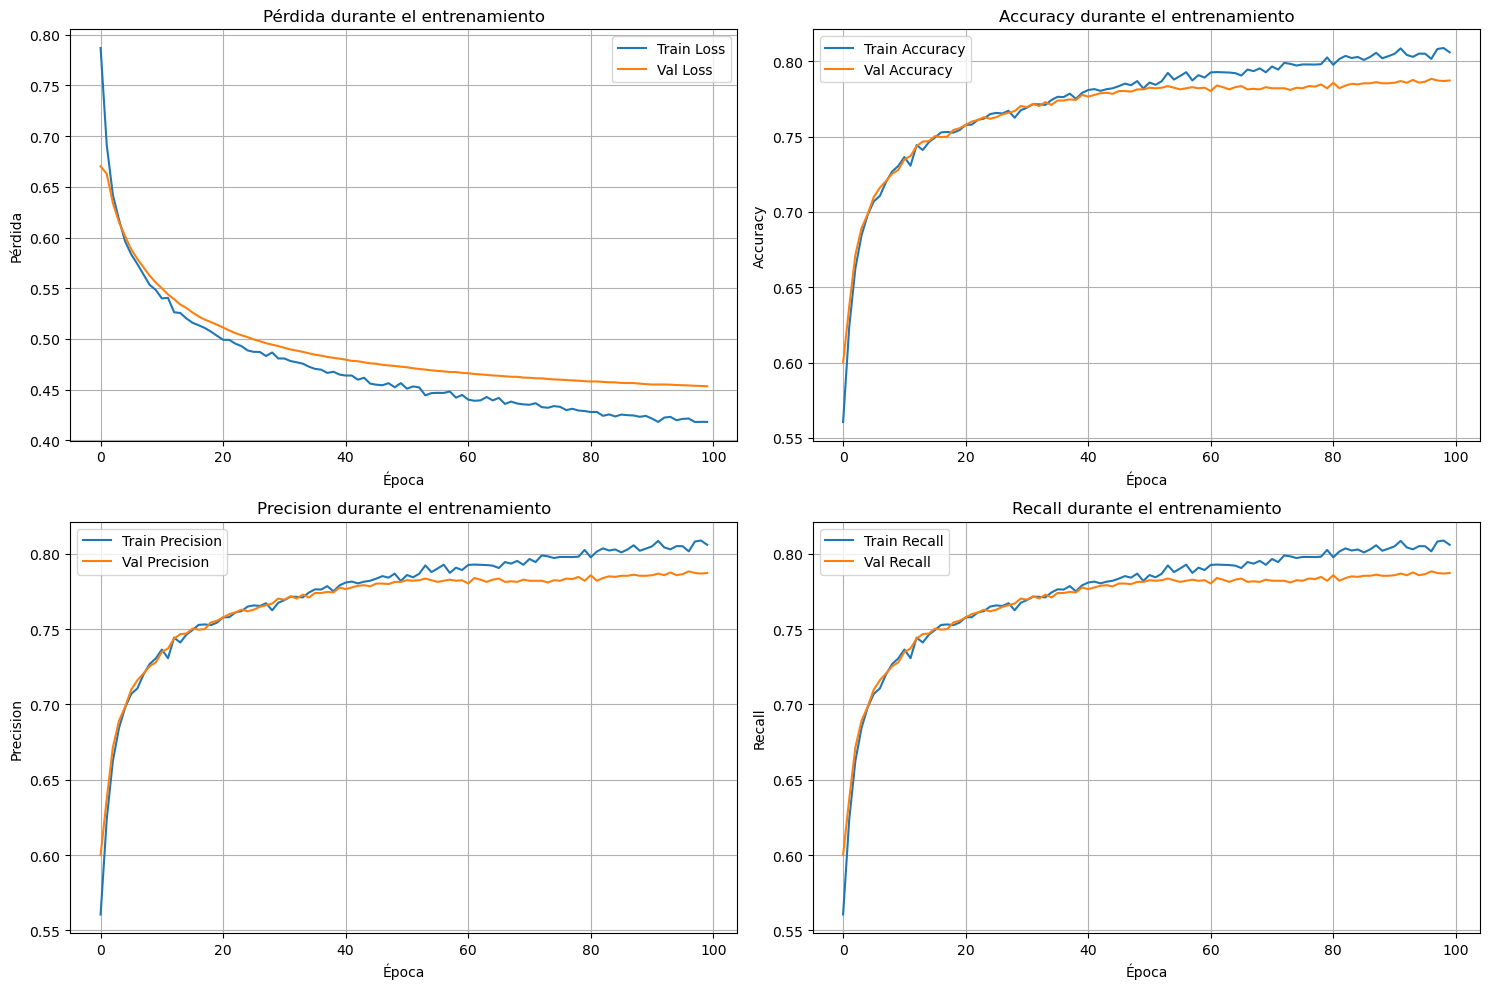

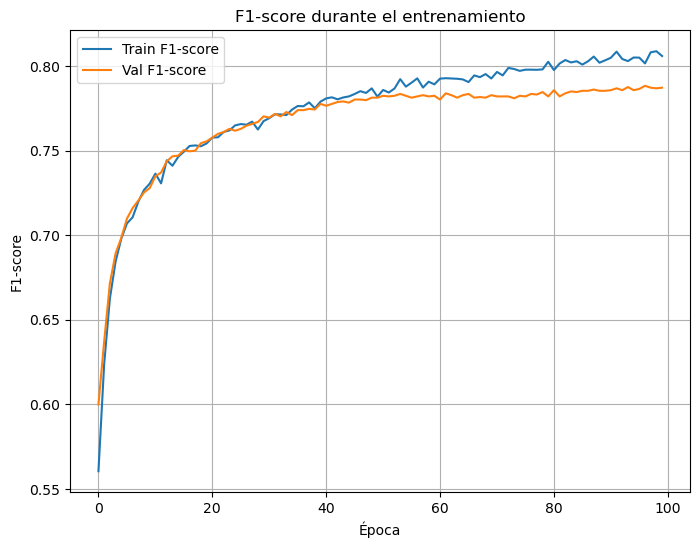

Evaluando en test set...

=== RESULTADOS FINALES ===
Test Loss: 0.4624
Test Accuracy: 0.7770
Test Precision: 0.7770
Test Recall: 0.7770
Test F1-score: 0.7770


NameError: name 'X_test' is not defined

In [15]:
def main():
    # 1. Cargar y preparar datos
    print("Cargando datos...")
    X, y = load_and_prepare_data()
    
    # 2. Dividir datos
    print("Dividiendo datos...")
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
    
    print(f"Train: {X_train.shape[0]} samples")
    print(f"Validation: {X_val.shape[0]} samples") 
    print(f"Test: {X_test.shape[0]} samples")
    
    # 3. Crear modelo
    print("Creando modelo VGG16...")
    model = create_vgg16_model(num_classes=2)
    
    # 4. Configurar entrenamiento
    callbacks = setup_training(model)
    
    # 5. Entrenar modelo
    print("Iniciando entrenamiento...")
    history = model.fit(
        X_train, y_train,
        batch_size=32,  # Minibatch size del paper
        epochs=100,    # Máximo de epochs del paper
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    # 6. Graficar curvas de aprendizaje
    print("\nGraficando curvas de aprendizaje...")
    plot_learning_curves(history)
    
    # 7. Evaluar en test
    print("Evaluando en test set...")
    test_results = model.evaluate(X_test, y_test, verbose=0)
    
    print("\n=== RESULTADOS FINALES ===")
    print(f"Test Loss: {test_results[0]:.4f}")
    print(f"Test Accuracy: {test_results[1]:.4f}")
    print(f"Test Precision: {test_results[2]:.4f}")
    print(f"Test Recall: {test_results[3]:.4f}")
    
    # Calcular F1-score
    precision = test_results[2]
    recall = test_results[3]
    f1 = 2 * (precision * recall) / (precision + recall)
    print(f"Test F1-score: {f1:.4f}")
    
    return model, history, test_results

# Ejecutar el entrenamiento
if __name__ == "__main__":
    model, history, results = main()
    evaluate_model(model, X_test, y_test)

    # Guardar el modelo
    model.save('vgg16_binary.keras')
    np.save('class_names.npy', ['not_informative', 'informative'])
    print("Modelo y mapeo de clases guardados")